# DATA MINING - GRUPPO 2

The purpose of the project is to try to deduce, using the dataset, a model capable of predicting given demographic and medical information (related to medical treatment, hospitalization time and drugs dispensed) the possible re-hospitalization of the patient in a period of time less than 30 days.

The first operation to be carried out consists in importing the dataset and the common libraries for the analysis of this dataset and the visualization of graphs.

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import re

from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

df = pd.read_csv("dataset_diabetes/diabetic_data.csv", low_memory=False, delimiter=',', na_values='?')

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [40]:
print(df.columns.to_list())

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


The dataset contains 101766 rows and 50 columns.
In particular, the columns can be grouped into macro categories:
    - Some columns provide patient data such as race, gender, age, and weight.
    - Some columns provide the diagnoses associated with the patient (diag_1, diag_2, diag_3).
    - Some columns provide information related to the medications taken by the patient and                specifically related to the change in quantity of the given medication.
    - Some columns provide "special" information, identifying the specific encounter (encouter_id)        or the patient's code (patient_nbr).



A preliminary operation that you can perform is to unify the target labels. In particular, within the dataset, the readmitted column has three values: '<30', '>30' and 'NO'. Since the purpose of our analysis is to identify the re-admission in a temporal range of less than 30 days, 'NO' and '>30' represent the same concept. 

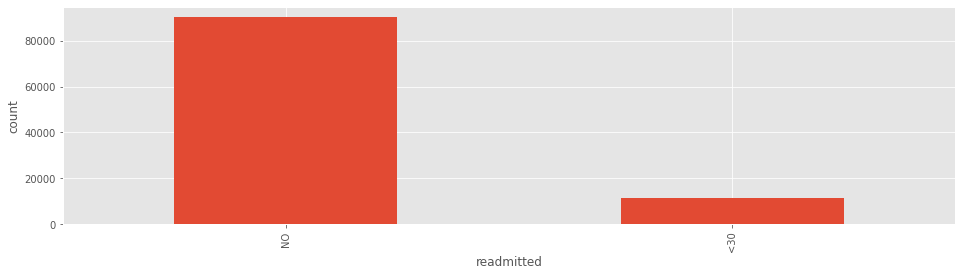

In [41]:
# Unify Labels
def unify_value(x: pd.Series) -> pd.Series:
    if x['readmitted'] == '>30':
        x['readmitted'] = 'NO'
    return x

df = df.apply(unify_value, axis=1)

# Plot target label values frequency
val = df['readmitted'].value_counts()
val.plot(kind='bar', figsize=(16,4))
plt.ylabel('count')
plt.xlabel('readmitted')
plt.show()


As we can see from the graph there is a strong disproportion between the tuples tagged as positive and negative. It will be necessary to keep this factor in mind in future analysis.

Let's check now the possible presence and relative frequency of NaN value.

In [42]:
df.isna().apply(lambda x: f'{round((sum(x) / df.shape[0]) * 100, 1)}%')

encounter_id                 0.0%
patient_nbr                  0.0%
race                         2.2%
gender                       0.0%
age                          0.0%
weight                      96.9%
admission_type_id            0.0%
discharge_disposition_id     0.0%
admission_source_id          0.0%
time_in_hospital             0.0%
payer_code                  39.6%
medical_specialty           49.1%
num_lab_procedures           0.0%
num_procedures               0.0%
num_medications              0.0%
number_outpatient            0.0%
number_emergency             0.0%
number_inpatient             0.0%
diag_1                       0.0%
diag_2                       0.4%
diag_3                       1.4%
number_diagnoses             0.0%
max_glu_serum                0.0%
A1Cresult                    0.0%
metformin                    0.0%
repaglinide                  0.0%
nateglinide                  0.0%
chlorpropamide               0.0%
glimepiride                  0.0%
acetohexamide 

As we can see the columns weight, player_code and medical_specialty have a high percentage of NaN value, so we proceed to delete the columns.

In [43]:
df = df.drop(columns=['weight', 'payer_code', 'medical_specialty'])

Another thing is valid for the race, which besides being probably an important information for the analysis, has a low percentage of NaN value. 
The attribute results to be NaN, moreover, for only 1.66% of the rows tagged as positive, consequently we can discard those rows without loss of information.

In [44]:
amount = df[(df['race'].isnull()) & (df['readmitted'] == '<30')].shape[0]
total = df[(df['readmitted'] == '<30')].shape[0]
percentage = ( amount / total) * 100
print(f'Percentage of race NaN value in positive rows: {percentage:.2f}%')

Percentage of race NaN value in positive rows: 1.66%


In [45]:
df = df.drop(df[(df['race'].isnull())].index)

Similar discussion as above applies to gender.

In [46]:
df = df.drop(df[(df['gender'].isnull())].index)
df = df.drop(df[(df['gender'] == 'Unknown/Invalid')].index)

Many of the pathologies reported in the dataset (afferent to the diag columns) are part of disease macrogroups (as indicated by documentation). Consequently, we decided to group them. Particular is the category other, which contains ranges of pathologies not very frequent in the dataset.

In [47]:
df[['diag_1', 'diag_2', 'diag_3']].fillna("Other", inplace=True)

c:\users\mlori\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [48]:
df['diag_1'] = df['diag_1'].astype(str)
df['diag_2'] = df['diag_2'].astype(str)
df['diag_3'] = df['diag_3'].astype(str)

def unify_disease_group(x: pd.Series) -> pd.Series:
    for i in range(1, 4):
        if not x['diag_' + str(i)].isnumeric() and re.match(r'^-?\d+(?:\.\d+)$', x['diag_' + str(i)]) is None:
            x['diag_' + str(i)] = 'Other'
        elif re.match(r'^-?\d+(?:\.\d+)$', x['diag_' + str(i)]) is not None and "250." not in x['diag_' + str(i)]:
            x['diag_' + str(i)] = 'Other'
        elif "250." in x['diag_' + str(i)]:
            x['diag_' + str(i)] = 'Diabetes'
        elif (int(x['diag_' + str(i)]) >= 390 and int(x['diag_' + str(i)]) <= 459) or int(x['diag_' + str(i)]) == 785:
                x['diag_' + str(i)] = 'Circulatory'
        elif (int(x['diag_' + str(i)]) >= 460 and int(x['diag_' + str(i)]) <= 519) or int(x['diag_' + str(i)]) == 786:
                x['diag_' + str(i)] = 'Respiratory'
        elif int(x['diag_' + str(i)]) <= 579 or int(x['diag_' + str(i)]) == 787:
            x['diag_' + str(i)] = 'Digestive'
        elif int(x['diag_' + str(i)]) >= 800 and int(x['diag_' + str(i)]) <= 999:
            x['diag_' + str(i)] = 'Injury'
        elif int(x['diag_' + str(i)]) >= 710 and int(x['diag_' + str(i)]) <= 739:
            x['diag_' + str(i)] = 'Muscoloskeletal'
        elif (int(x['diag_' + str(i)]) >= 580 and int(x['diag_' + str(i)]) <= 629) or int(x['diag_' + str(i)]) == 788:
            x['diag_' + str(i)] = 'Genitourinary'
        elif int(x['diag_' + str(i)]) >= 140 and int(x['diag_' + str(i)]) <= 239:
            x['diag_' + str(i)] = 'Neoplasm'
        else:
            x['diag_' + str(i)] = 'Other'
    return x

df = df.apply(unify_disease_group, axis=1)

In [49]:
def merge_ids(series: pd.Series) -> pd.Series:
    if series['admission_type_id'] == 5 or series['admission_type_id'] == 6:
        series['admission_type_id'] = 8
    if series['discharge_disposition_id'] == 18 or series['discharge_disposition_id'] == 26:
        series['discharge_disposition_id'] = 25
    if series['admission_source_id'] == 9 or series['admission_source_id'] == 15 or series['admission_source_id'] == 17 or series['admission_source_id'] == 21:
        series['admission_source_id'] = 20
    return series

df = df.apply(merge_ids, axis=1)

Analyzing the types automatically deduced by pandas we notice that the columns with id are mapped as 'int64' even though they refer to categorical concepts. We proceed to fix the types.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              99492 non-null  int64 
 1   patient_nbr               99492 non-null  int64 
 2   race                      99492 non-null  object
 3   gender                    99492 non-null  object
 4   age                       99492 non-null  object
 5   admission_type_id         99492 non-null  int64 
 6   discharge_disposition_id  99492 non-null  int64 
 7   admission_source_id       99492 non-null  int64 
 8   time_in_hospital          99492 non-null  int64 
 9   num_lab_procedures        99492 non-null  int64 
 10  num_procedures            99492 non-null  int64 
 11  num_medications           99492 non-null  int64 
 12  number_outpatient         99492 non-null  int64 
 13  number_emergency          99492 non-null  int64 
 14  number_inpatient     

As shown in the 'IDs_mapping.csv' file some of the IDs associated with the 'admission_type_id', 'discharge_disposition_id' and 'admission_source_id' columns refer to similar concepts. For the purpose of the analysis in fact there are substantially more ways to indicate the 'Not Mapped Value'. Therefore we proceed to unify these values.

In [51]:
for attribute in df.columns:
    if df[attribute].dtype == np.object:
        df[attribute] = df[attribute].astype('category')

df['admission_type_id'] = df['admission_type_id'].astype('category')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')
df['admission_source_id'] = df['admission_source_id'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              99492 non-null  int64   
 1   patient_nbr               99492 non-null  int64   
 2   race                      99492 non-null  category
 3   gender                    99492 non-null  category
 4   age                       99492 non-null  category
 5   admission_type_id         99492 non-null  category
 6   discharge_disposition_id  99492 non-null  category
 7   admission_source_id       99492 non-null  category
 8   time_in_hospital          99492 non-null  int64   
 9   num_lab_procedures        99492 non-null  int64   
 10  num_procedures            99492 non-null  int64   
 11  num_medications           99492 non-null  int64   
 12  number_outpatient         99492 non-null  int64   
 13  number_emergency          99492 non-null  int

As we can see, the columns 'examide' and 'cytoglipton' have a single value for the entire datasat extension. As they represent a low information gain we discard them.

In [52]:
df[['examide', 'citoglipton']].describe()

,examide,citoglipton
count,99492,99492
unique,1,1
top,No,No
freq,99492,99492


In [53]:
df = df.drop(columns=['examide', 'citoglipton'])

Since the columns 'encounter_id' and 'patient_nbr' represented mainly a type of bureaucratic/administrative information, we discard them from the dataset.

In [54]:
df = df.drop(columns=['encounter_id', 'patient_nbr'])

Some columns in the dataset have extremely high or extremely low variance, thus representing columns with low information gain. We therefore decided to discard them.

In [55]:
info_columns = df.describe(include='category').T
info_columns

,count,unique,top,freq
race,99492,5,Caucasian,76099
gender,99492,2,Female,53575
age,99492,10,[70-80),25468
admission_type_id,99492,6,1,52900
discharge_disposition_id,99492,25,1,58767
admission_source_id,99492,15,7,56632
diag_1,99492,8,Circulatory,29753
diag_2,99492,8,Circulatory,31179
diag_3,99492,8,Digestive,34916
max_glu_serum,99492,4,None,94202


We can then now view the graphs on the distribution of numerical attributes

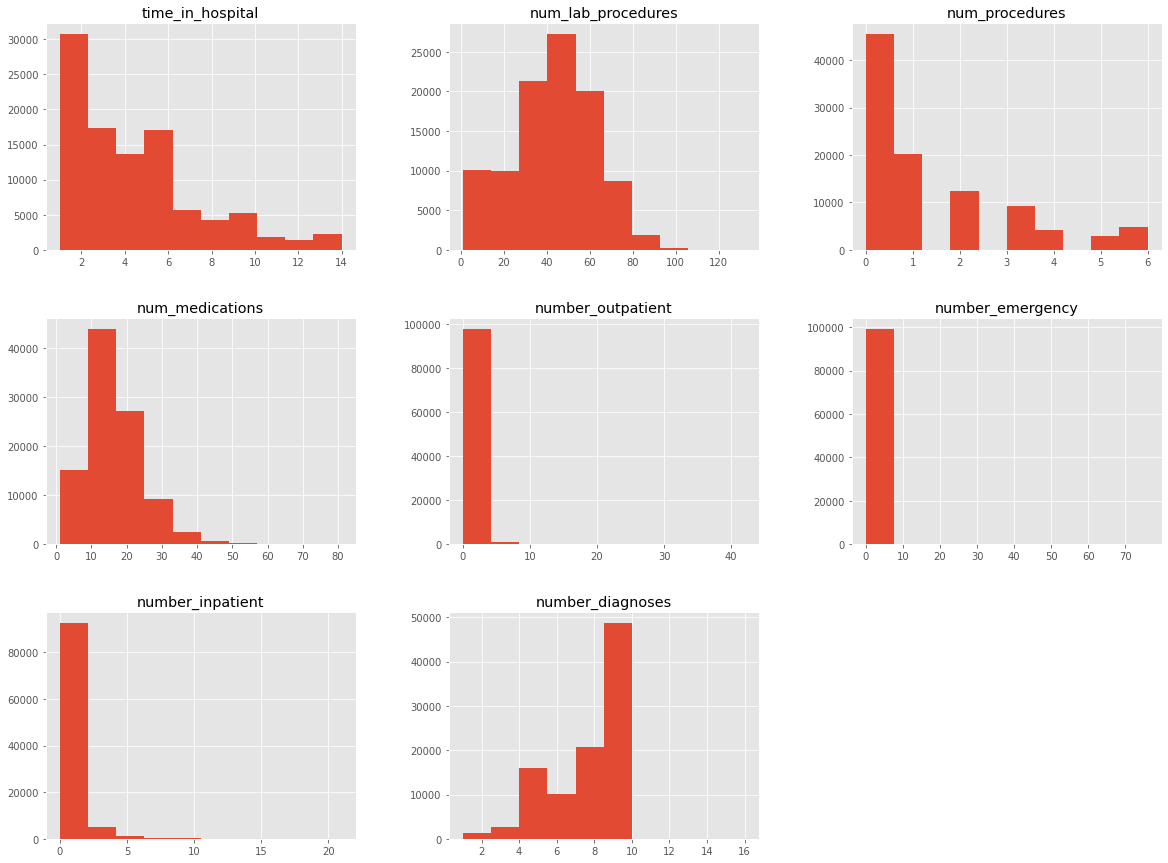

In [56]:
df.select_dtypes(include=['int64']).hist(figsize=(20,15))
plt.show()

By exploiting box plots we can highlight any outliers.

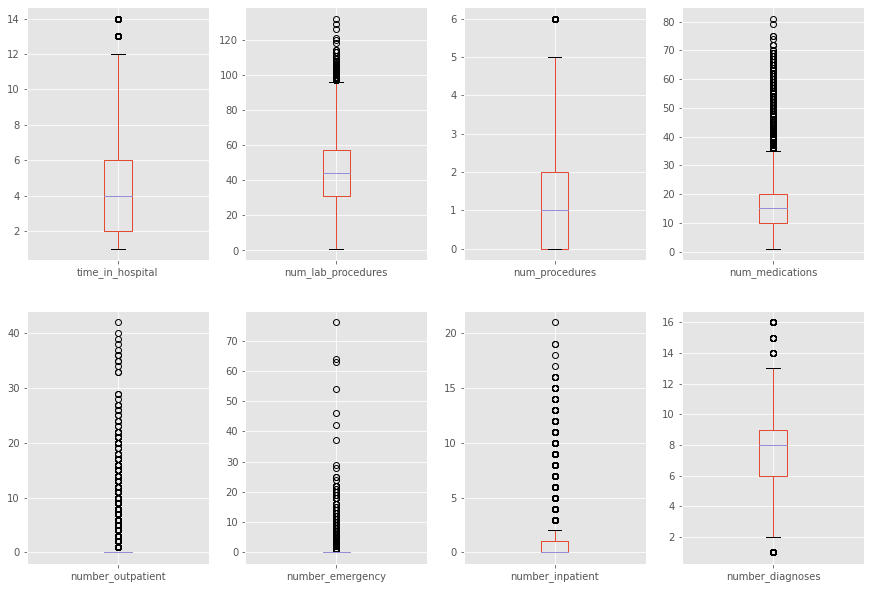

In [57]:
df.select_dtypes(include=['int64']).plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(15, 27), layout=(5, 4))
plt.show()

As shown by the boxplots some columns have an excessive number of outliers. Since they would not be useful for the model we proceed to eliminate them.

In [58]:
df = df.drop(columns=['number_outpatient', 'number_emergency', 'number_inpatient', 'num_medications', 'num_lab_procedures'])

In [59]:
df['time_in_hospital'] = pd.cut(df['time_in_hospital'].values, bins=[0, 2 , 6, 10, 14], labels = ('0-2', '3-6', '7-10', '11-14'))
df['time_in_hospital'] = df['time_in_hospital'].astype('category')
df['num_procedures'] = pd.cut(df['num_procedures'].values, bins=[0, 1, 4, 6], labels = ('0-1', '2-4', '5-6'))
df['num_procedures'] = df['num_procedures'].astype('category')
df['number_diagnoses'] = pd.cut(df['number_diagnoses'].values, bins=[0, 5, 8, 10, 16], labels = ('0-5', '6-8', '9-10', '11-16'))
df['number_diagnoses'] = df['number_diagnoses'].astype('category')


We chose two boundary margins as lower bound and upper bound, because we noticed that by increasing these margins too much information is lost

In [60]:
upper_bound = 95
lower_bound = 0

info_columns['freq'] = info_columns['freq'].apply(lambda x: round((x / df.shape[0]) * 100, 1))
for info in info_columns.index:
    if info_columns.loc[info]['freq'] > upper_bound or info_columns.loc[info]['freq'] < lower_bound:
        df = df.drop(columns=[info])

We can now view the graphs on the distribution of categorical attributes

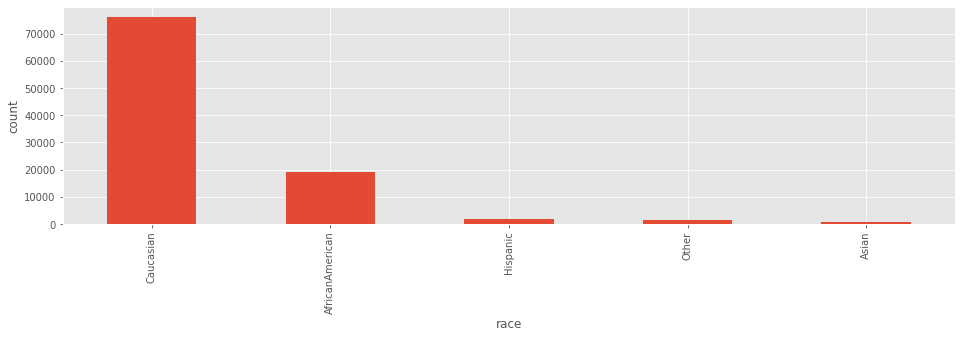

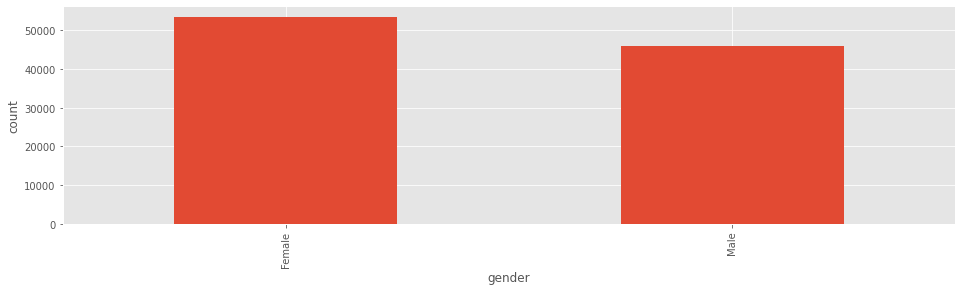

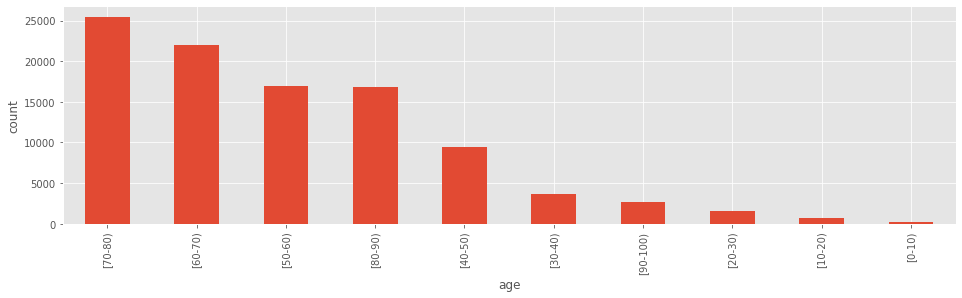

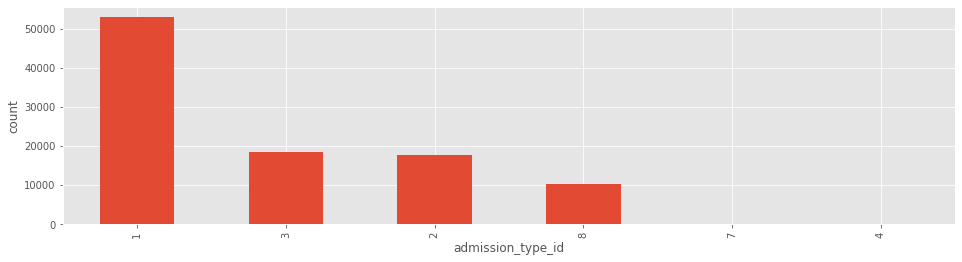

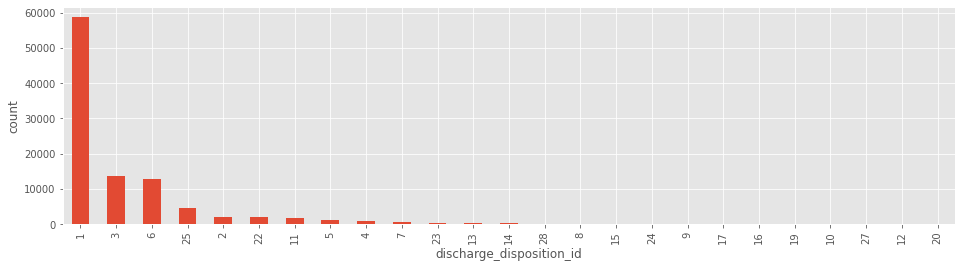

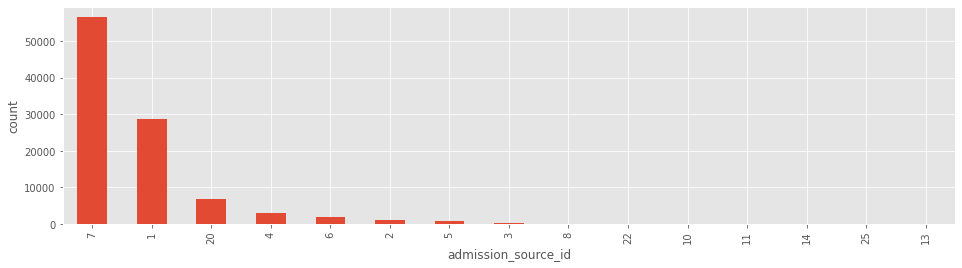

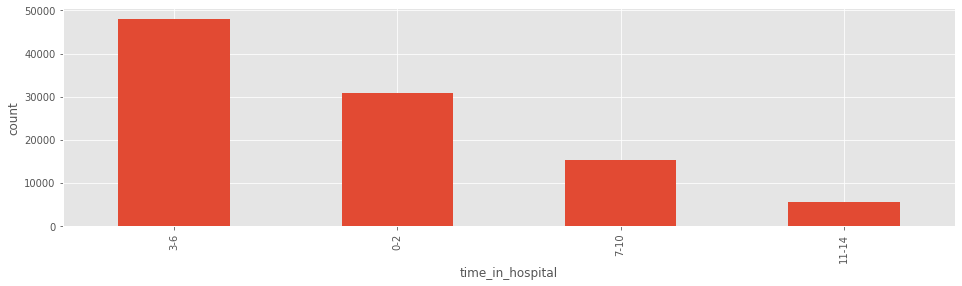

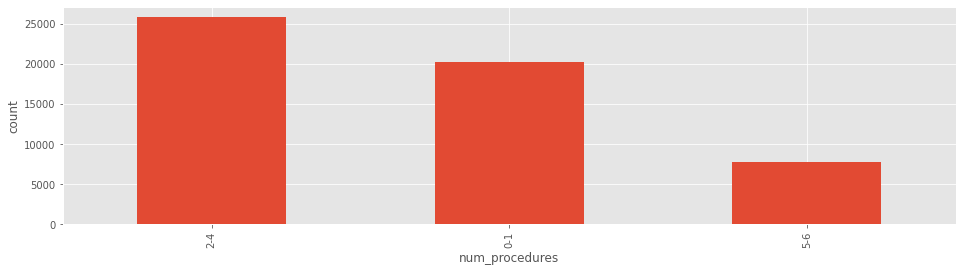

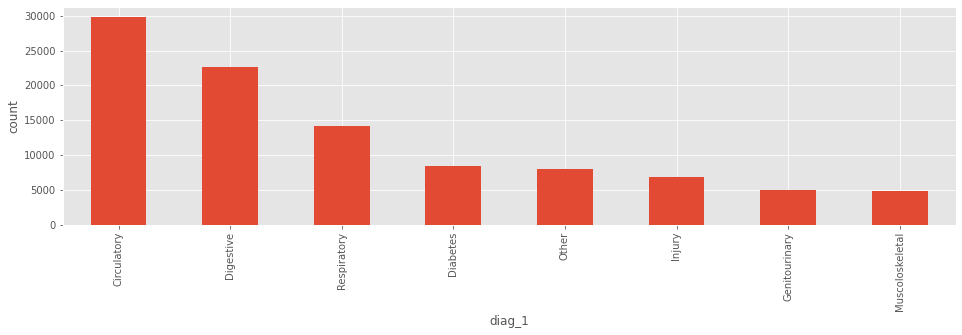

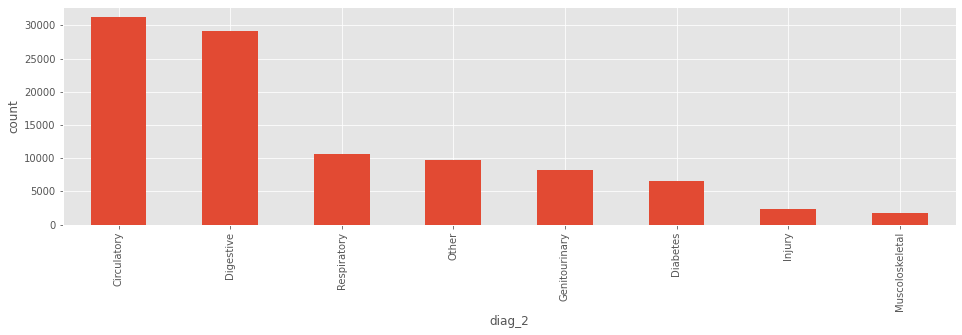

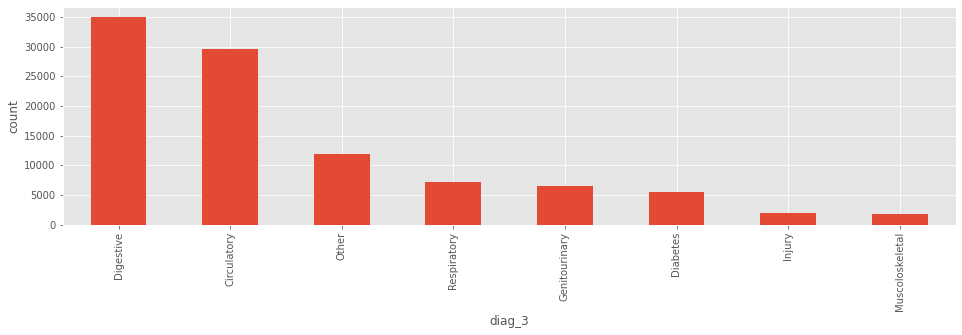

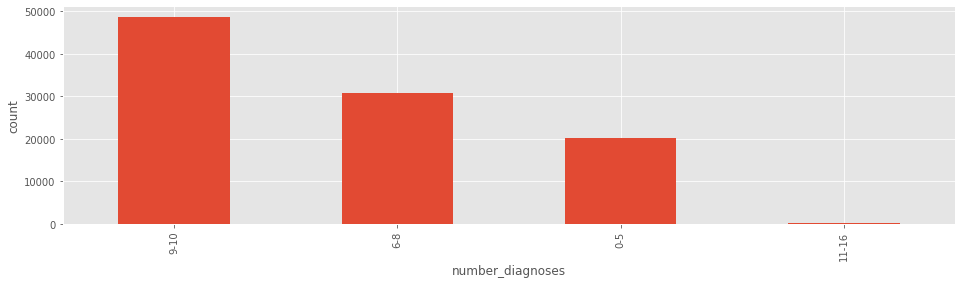

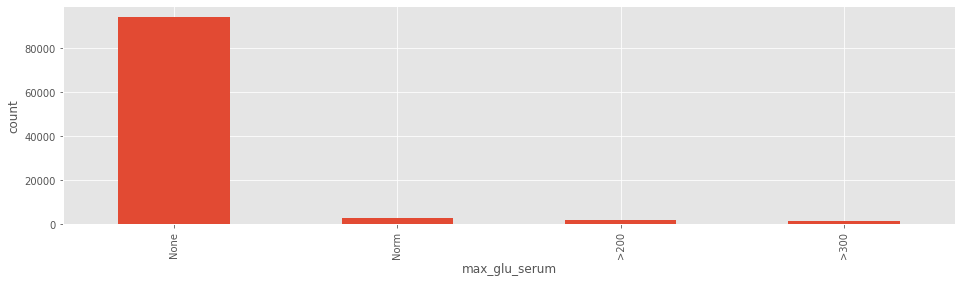

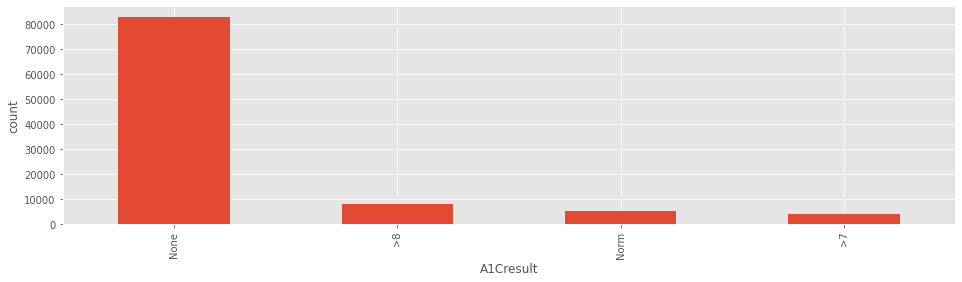

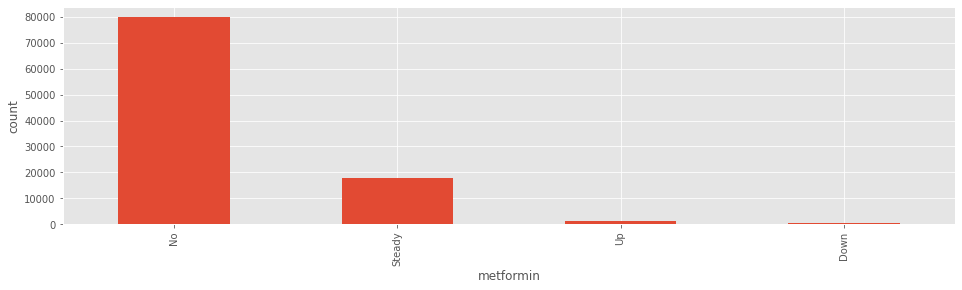

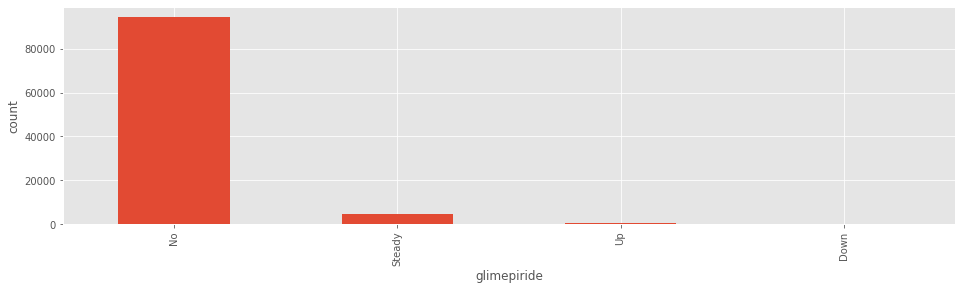

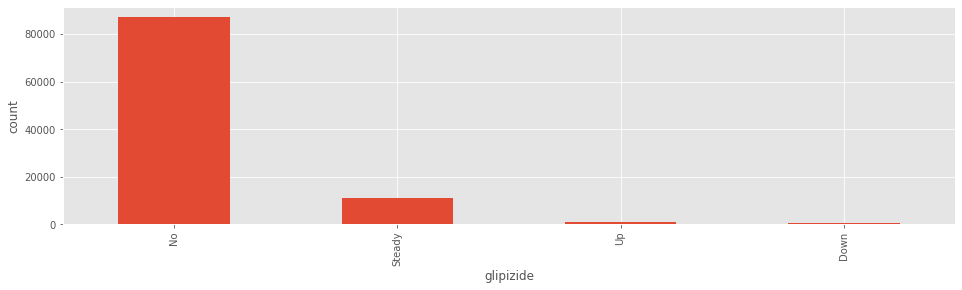

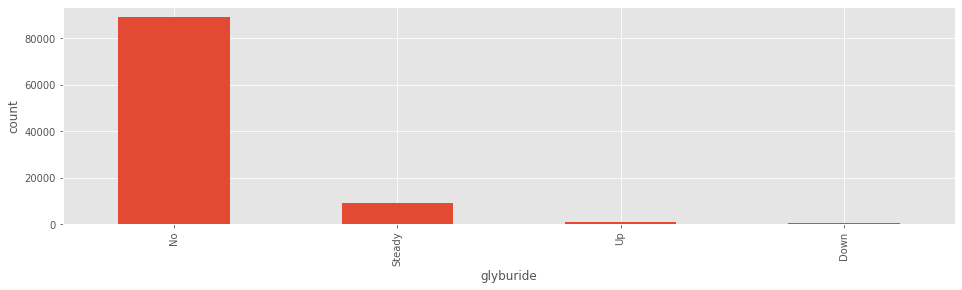

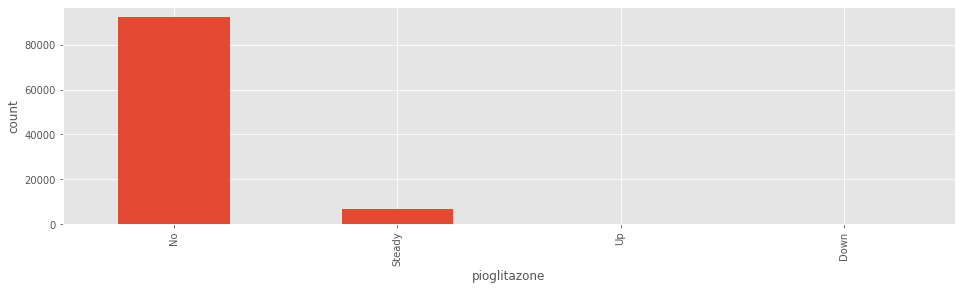

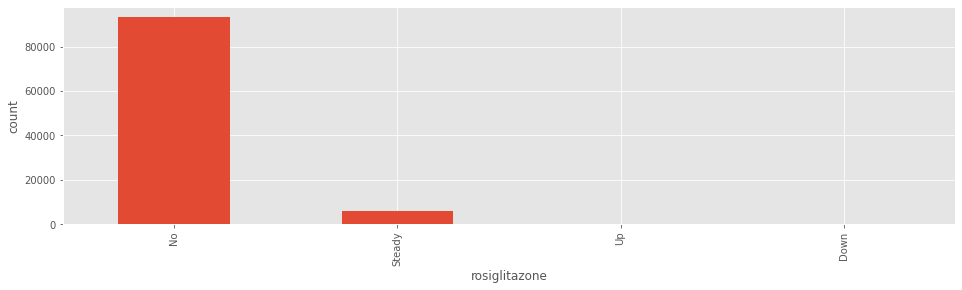

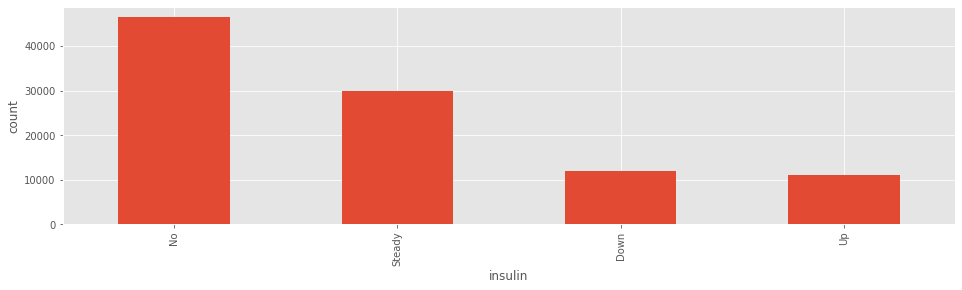

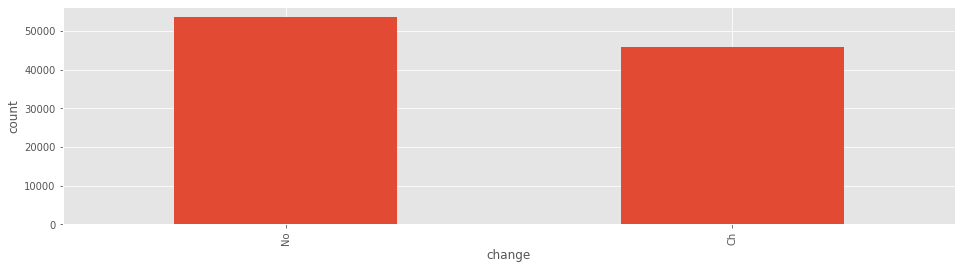

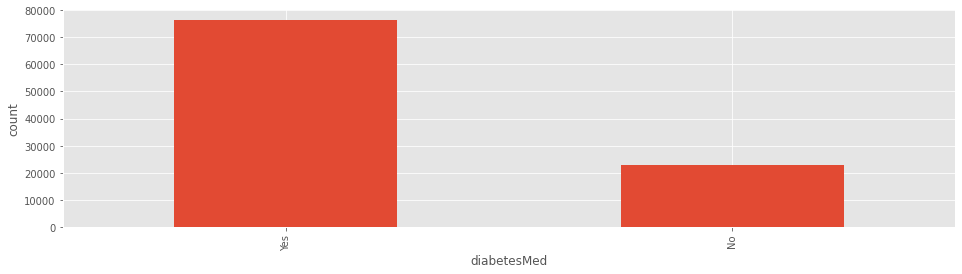

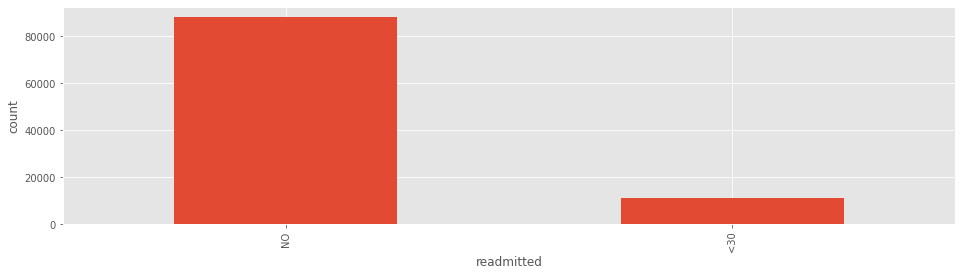

In [61]:
categorical_attr = df.select_dtypes(include=['category']).columns.to_list()
for attribute in categorical_attr:
    val = df[attribute].value_counts()
    val.plot(kind='bar', figsize=(16,4))
    plt.ylabel('count')
    plt.xlabel(attribute)
    plt.show()

We can then now visualize graphs on the correlation between numeric attributes and class label.

In [62]:
numericAttribute = df.select_dtypes(include=['int64']).columns.to_list()
numericAttribute.append('readmitted')

for attribute in numericAttribute:
    if attribute != 'readmitted':
        plt.clf()
        fig, ax = plt.subplots(figsize=(16, 4))
        sb.kdeplot(x= df[attribute], hue= 'readmitted', data=df[numericAttribute], ax=ax)
        plt.show()


We can then now visualize graphs on the correlation between categorical attributes and class label. Given the huge disproportion between the frequency of the two class labels, we decided to normalize the counts and express them as a percentage.

<Figure size 432x288 with 0 Axes>

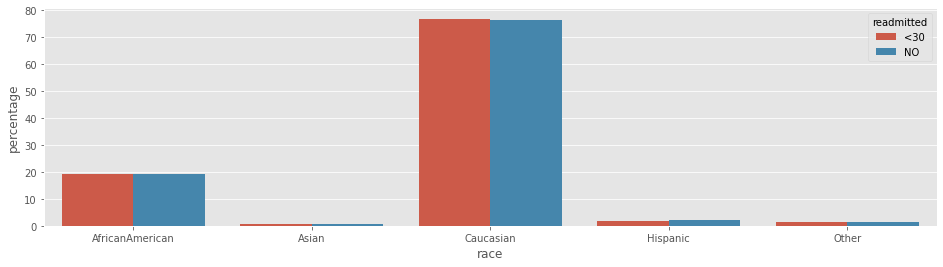

<Figure size 432x288 with 0 Axes>

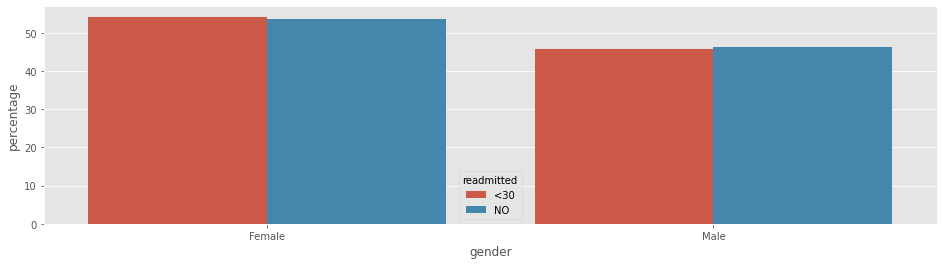

<Figure size 432x288 with 0 Axes>

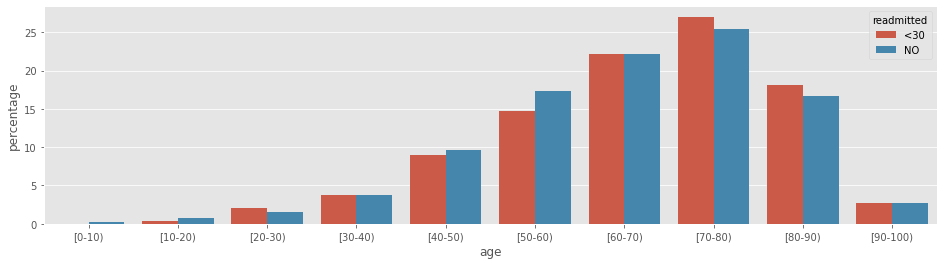

<Figure size 432x288 with 0 Axes>

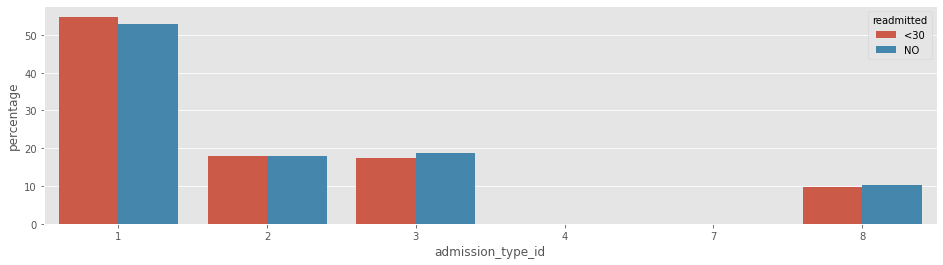

<Figure size 432x288 with 0 Axes>

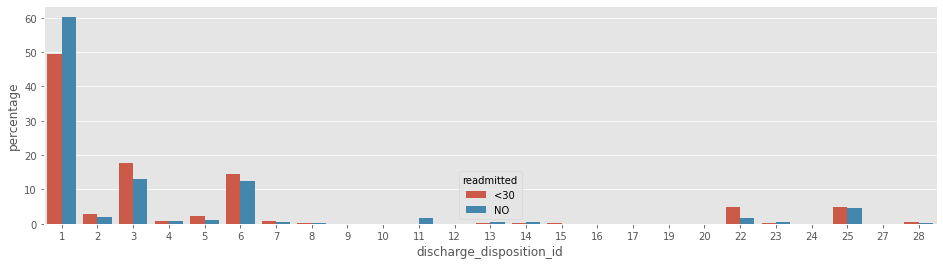

<Figure size 432x288 with 0 Axes>

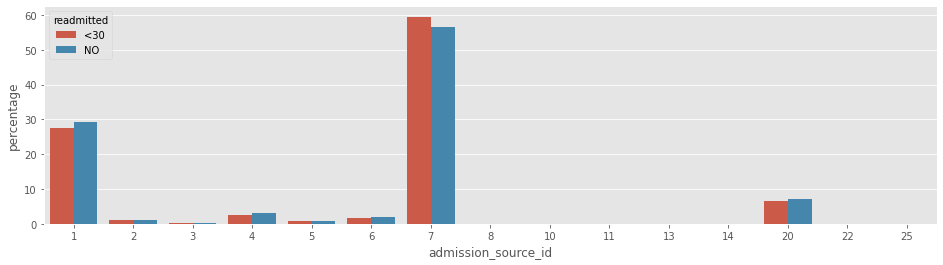

<Figure size 432x288 with 0 Axes>

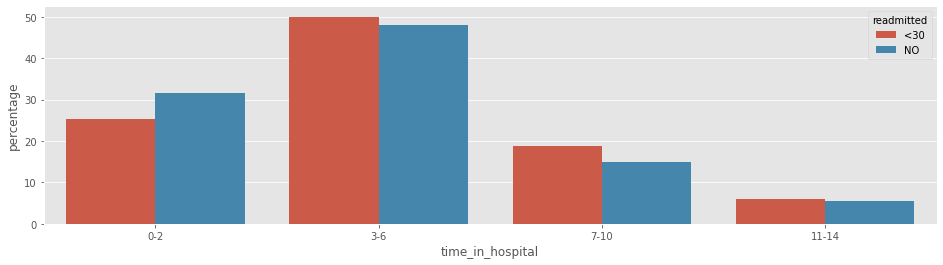

<Figure size 432x288 with 0 Axes>

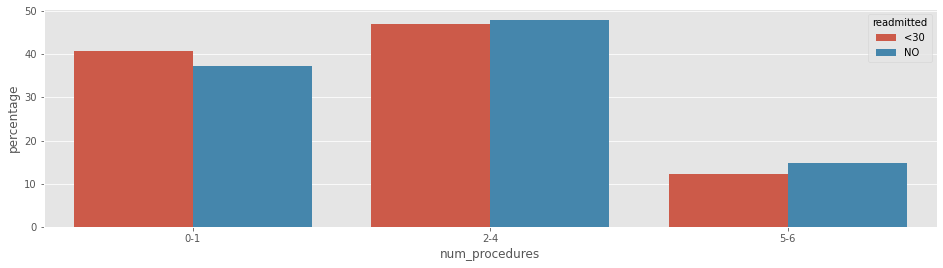

<Figure size 432x288 with 0 Axes>

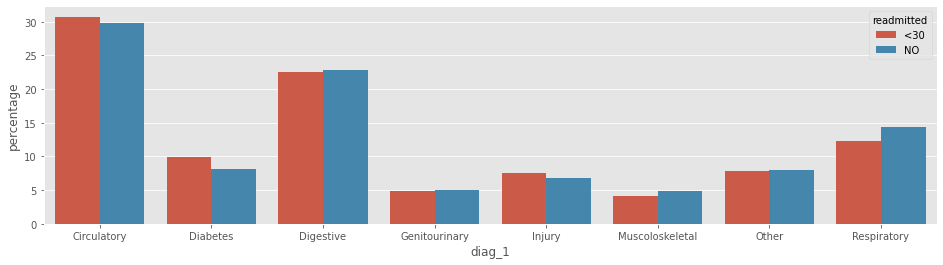

<Figure size 432x288 with 0 Axes>

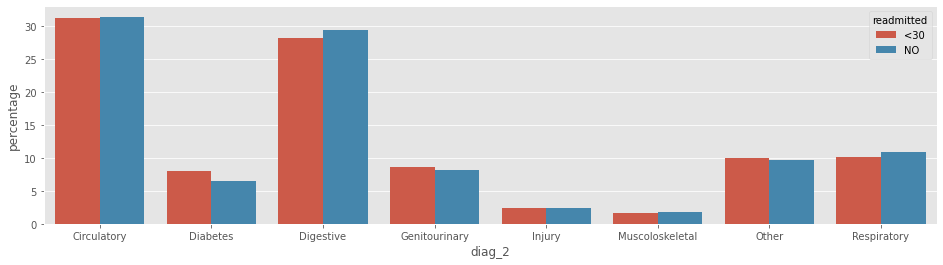

<Figure size 432x288 with 0 Axes>

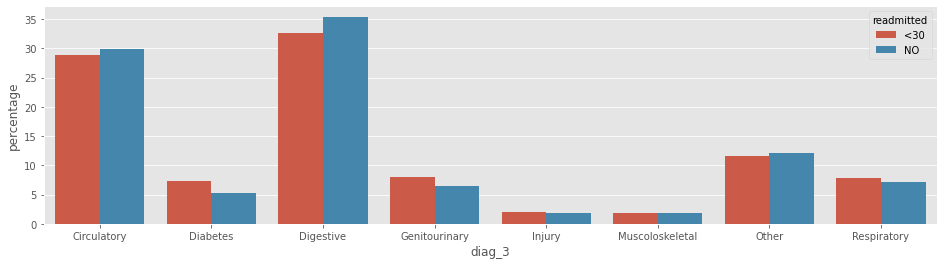

<Figure size 432x288 with 0 Axes>

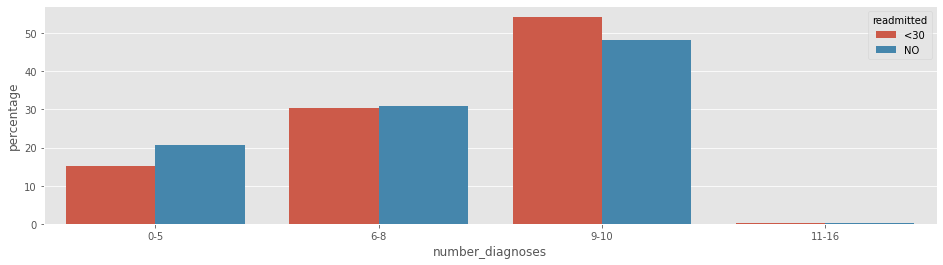

<Figure size 432x288 with 0 Axes>

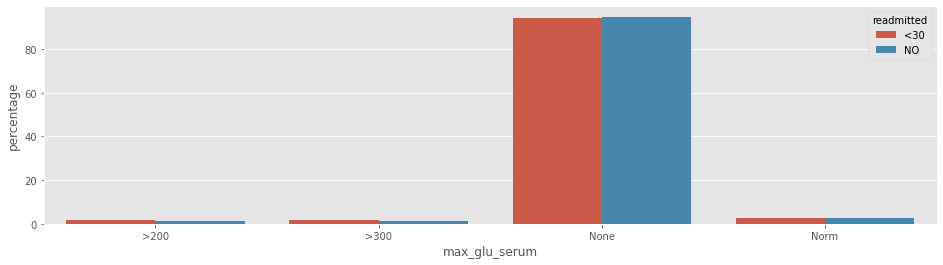

<Figure size 432x288 with 0 Axes>

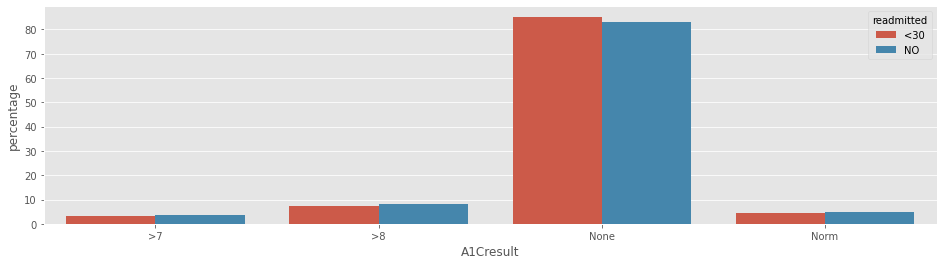

<Figure size 432x288 with 0 Axes>

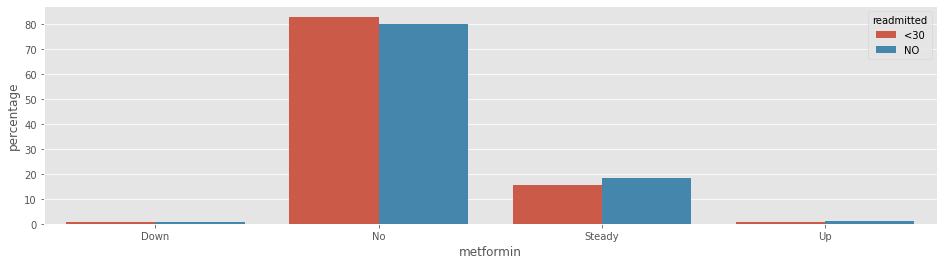

<Figure size 432x288 with 0 Axes>

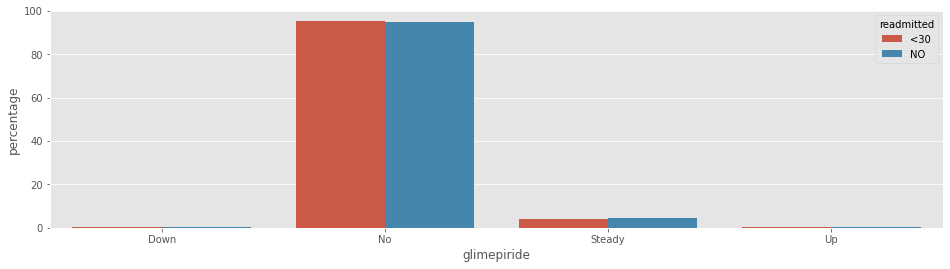

<Figure size 432x288 with 0 Axes>

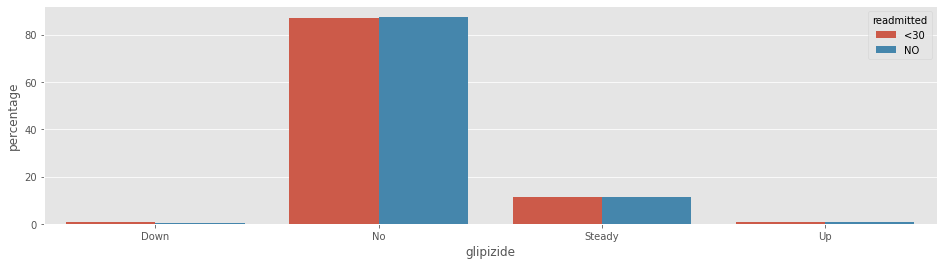

<Figure size 432x288 with 0 Axes>

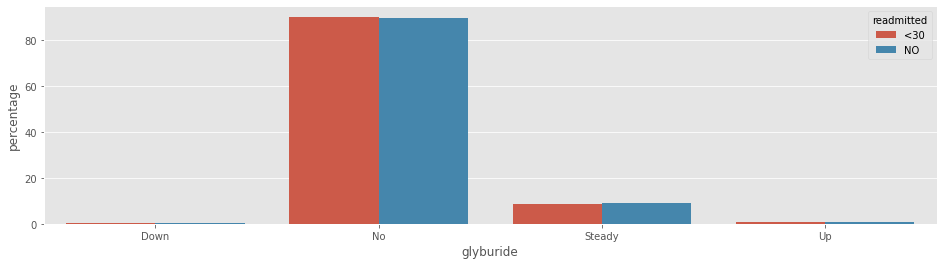

<Figure size 432x288 with 0 Axes>

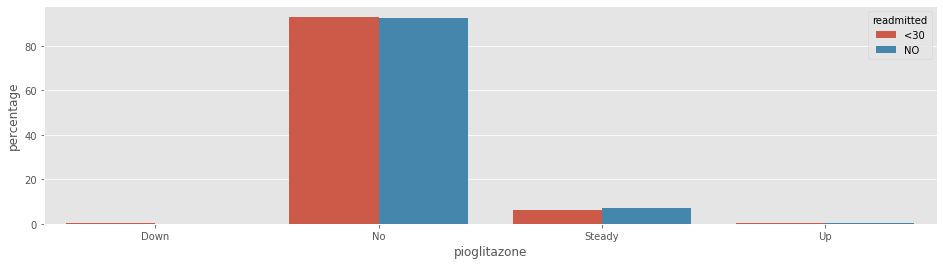

<Figure size 432x288 with 0 Axes>

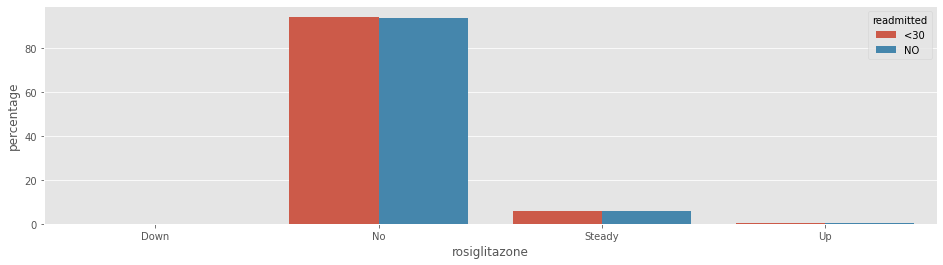

<Figure size 432x288 with 0 Axes>

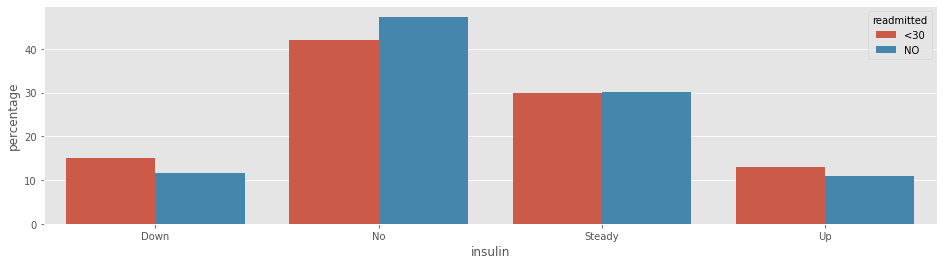

<Figure size 432x288 with 0 Axes>

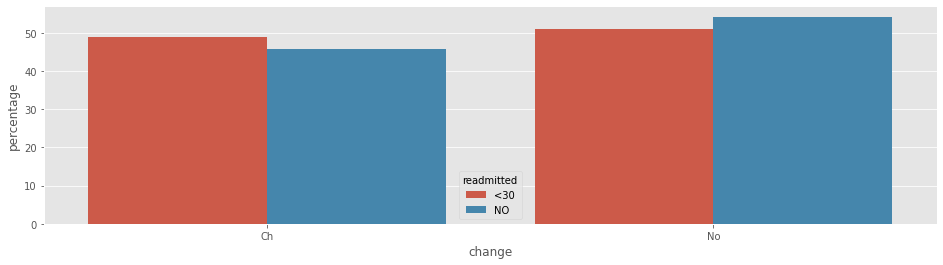

<Figure size 432x288 with 0 Axes>

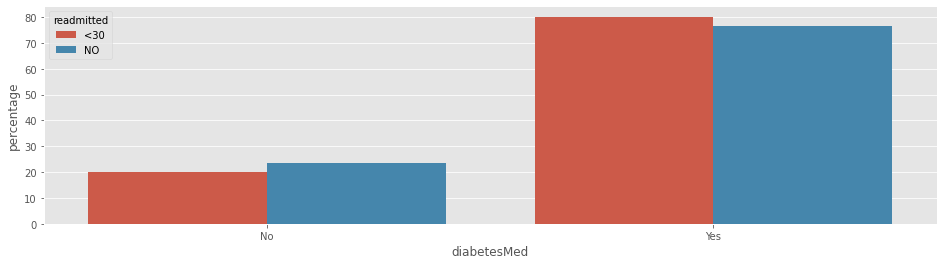

In [63]:
categoricalAttributes = df.select_dtypes(include=['category']).columns.to_list()
categoricalAttributes.append('readmitted')

for attribute in categoricalAttributes:
    if attribute != 'readmitted':
        attributeCounts = (df.groupby(['readmitted'])[attribute]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(attribute))
        plt.clf()
        fig, ax = plt.subplots(figsize=(16, 4))
        p = sb.barplot(x=attribute, y="percentage", hue="readmitted", data=attributeCounts, ax=ax)
        plt.show()

As the graphs show, some attribute values have a much lower relative frequency than others. We therefore decided to discard those rows as they are not very representative.

In [64]:
minFreq = 4

categoricalAttributes = df.select_dtypes(include=['category']).columns.to_list()
for attribute in categoricalAttributes:
    if attribute != 'readmitted':
        for columnValue in df[attribute].unique().tolist():
            if (df[df[attribute] == columnValue].shape[0]/df.shape[0]) * 100 < minFreq:
                df = df.drop(df[df[attribute] == columnValue].index)

As for the other numeric attributes, the best solution is to group the values into ranges.

At this point we have only categorical attributes

To improve model performance we proceed to binarize the categorical data.

In [65]:
cat_attributes = list(df.select_dtypes(include = ['category']).columns)
cat_attributes.remove('readmitted')
df2 = pd.get_dummies(df, columns = cat_attributes)
new_attr_list = list(df2.columns)
new_attr_list.remove('readmitted')
df2 = df2[new_attr_list]

df2.columns

Index(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'age_[0-10)',
       'age_[10-20)', 'age_[20-30)',
       ...
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'insulin_Down',
       'insulin_No', 'insulin_Steady', 'insulin_Up', 'change_Ch', 'change_No',
       'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object', length=138)

Considering the aforementioned disproportion between the frequencies of the two class labels, we performed an oversampling operation on the dataset.
To perform this operation we used the imbalanced-learn library which provides various algorithms including SMOTE.
SMOTE once configured and fitted on a dataset, will transform the dataset increasing the number of minority labels.

We performed several tests on different models identifying the RandomForestClassifierModel as most promising.



In [28]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#x_train, x_test, y_train, y_test = train_test_split(df2[new_attr_list], df['readmitted'], test_size=0.4, random_state=0)
x = np.array(df2.values)
y = np.array(df['readmitted'].values)
# define oversampling strategy

seed = 121
test_size = .2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# define oversampling strategy

scaler= StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

SMOTE = SMOTE()

# fit and apply the transform
x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)


In [29]:
# models = []
# models.append(('KNeighborsClassifier', KNeighborsClassifier(3)))
# # models.append(('C45', DecisionTreeClassifier(criterion='entropy')))
# # models.append(('DecisionTreeClassifier', DecisionTreeClassifier( splitter="random", random_state=1, max_depth=5, max_leaf_nodes=15)))
# models.append(('RandomForestClassifier', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=24)))
# # models.append(('MLPClassifier',MLPClassifier(alpha=1, max_iter=1000)))
# models.append(('AdaBoostClassifier',  AdaBoostClassifier()))
# # models.append(('GaussianNaiveBayes', GaussianNB()))
# # models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
# for name, model in models:
#     kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
#     cv_results = cross_val_score(model, x_train_SMOTE, y_train_SMOTE, cv=kfold, scoring='accuracy')
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

### **Evaluation**

As shown from the confusion matrix the model has a good precision and recall on the labels 'No', while for the labels '<30' because of the insufficient representivity of the dataset is not succeeded to obtain high performances.


In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [219]:
# AdaBoostClassifierModel =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=24)
KNeighborsClassifierModel =  RandomForestClassifier(n_jobs=-1, max_depth=2, n_estimators=150, max_features='log2')
KNeighborsClassifierModel.fit(x_train_SMOTE, y_train_SMOTE)
KNeighborsClassifierModelPredictions = KNeighborsClassifierModel.predict(x_test)

In [220]:
print(f'Accuracy Adaboost: {accuracy_score(y_test, KNeighborsClassifierModelPredictions):.2f}')

Accuracy Adaboost: 0.64


In [221]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

In [222]:
KNeighborsClassifierModelPredictions

array(['NO', 'NO', '<30', ..., '<30', '<30', '<30'], dtype=object)

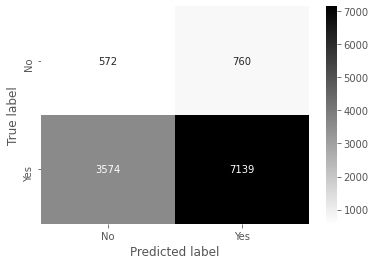

In [223]:
categories = ['No', 'Yes']
make_confusion_matrix(confusion_matrix(y_test, KNeighborsClassifierModelPredictions), categories=categories, cmap='binary')

In [224]:
print('KNeighborsClassifier Classification Report')
print(classification_report(y_test, KNeighborsClassifierModelPredictions))


KNeighborsClassifier Classification Report
              precision    recall  f1-score   support

         <30       0.14      0.43      0.21      1332
          NO       0.90      0.67      0.77     10713

    accuracy                           0.64     12045
   macro avg       0.52      0.55      0.49     12045
weighted avg       0.82      0.64      0.71     12045



Our intuition on the RandomForest model is confirmed also by the ROC Curve that show how the greater area is the one described by our model

In [225]:
from sklearn.metrics import roc_curve, auc

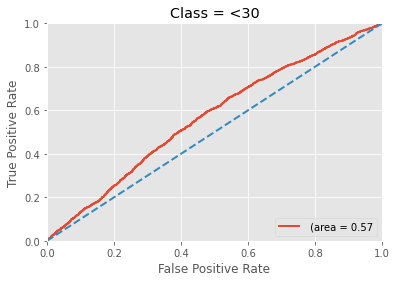

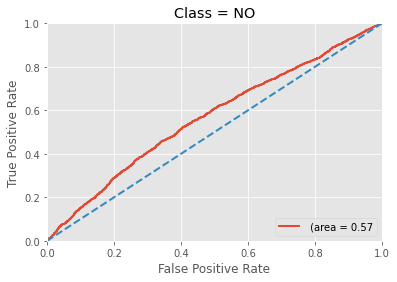

In [226]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['readmitted']))


probs = []

# for  _,model in models:
#     model.fit(x_train_SMOTE, y_train_SMOTE)
probs.append(KNeighborsClassifierModel.predict_proba(x_test))
    
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0

    # for name, _ in models:
    fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], lw=2, label=f' (area = {roc_auc[i]:.2f}')
    m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y)[i]))
    plt.legend(loc='lower right')

    plt.show()  